In [1]:
import sympy
sympy.init_printing()
import matplotlib.pyplot as plt
%matplotlib inline
import tbcontrol
tbcontrol.expectversion('0.1.3')

There is a difference between the $z$ transform of an impulse response and the equivalent z transform of a continuous system with a hold element.

Let's consider the system 

$$G(s) = \frac{K}{s + r}$$

In [2]:
s, z, q = sympy.symbols('s, z, q')
K, r, t = sympy.symbols('K, r, t', real=True)
Dt = sympy.Symbol(r'\Delta t', positive=True)

In [3]:
G = K/(s + r)

The _impulse response_ of this system is simply the inverse laplace transform:

In [4]:
import tbcontrol.symbolic

In [5]:
gt = sympy.inverse_laplace_transform(G, s, t)
gt

The $z$ transform of this function of time, sampled at a sampling rate of $\Delta t$ can be read off the table as

In [6]:
b = sympy.exp(-r*Dt)
Gz = K/(1 - b*z**-1)

Let's choose values and plot the response.

In [7]:
parameters = {K: 3, r: 0.25, Dt: 2}

In [8]:
import numpy

In [9]:
ts = numpy.linspace(0, 20)

In [10]:
terms = 10

In [11]:
def plot_discrete(Gz, N, Dt):
    ts = [Dt*n for n in range(N)]
    values = tbcontrol.symbolic.sampledvalues(Gz.subs(parameters), z, N)
    plt.stem(ts, values)

In [12]:
def values(expression, ts):
    return tbcontrol.symbolic.evaluate_at_times(expression.subs(parameters), t, ts)

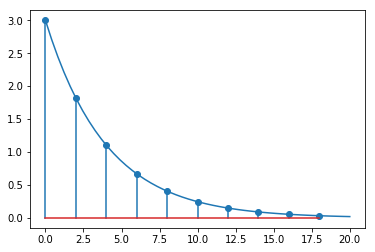

In [13]:
plt.plot(ts, values(gt, ts))
plot_discrete(Gz, terms, parameters[Dt])

But the value in Table 17.1 is

In [14]:
a1 = -b
b1 = K/r*(1 - b)
Gz_seborg = (b1 * z**-1)/(1 + a1*z**-1)

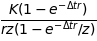

In [15]:
Gz_seborg

That's clearly not the same as the discrete transform in the datasheet. What is going on?

The values in the table in seborg are the z transform of the transfer function _with a hold element_!

The z-transform of this combination can be written $\mathcal{Z}\{H(s)G(s)\}$. Remember, $H(s) = \frac{1}{s}(1 - e^{-\Delta t s})$. Now we can show

\begin{align}
\mathcal{Z}\left\{{H(s)G(s)}\right\} &= 
                             \mathcal{Z}\left\{\frac{1}{s}(1 - e^{-Ts})G(s)\right\} \\
                          &= \mathcal{Z}\left\{\underbrace{\frac{G(s)}{s}}_{F(s)}(1 - e^{-Ts})\right\} \\
                           &= \mathcal{Z}\left\{F(s) - F(s)e^{-Ts}\right\} \\
                          &= \mathcal{Z}\left\{F(s)\right\} - \mathcal{Z}\left\{F(s)e^{-Ts}\right\} \\
                          &= F(z) - F(z)z^{-1} \\
                          &= F(z)(1 - z^{-1})
\end{align}
So the z transform we're looking for will be $F(z)(1 - z^{-1})$ with $F(z)$ being the transform on the right of the table of $\frac{1}{s}G(s)$.

To remind ourselves,

In [16]:
G

So we're looking for

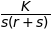

In [17]:
(G/s)

So we should see the same response if we plot this:


There is an element in the table for 

$$ \frac{a}{s(s + a)} $$ 

which is the same as what we want but multiplied by $a$. We should be able to use the associated $z$ transform:

In [18]:
a = r

In [19]:
table_value = (1 - b)*z**-1/((1 - z**-1)*(1 - b*z**-1))

In [20]:
Fz = K * table_value / a

In [21]:
Fz * (1 - z**-1) == Gz_seborg

True

In [22]:
response = sympy.inverse_laplace_transform(G/s, s, t)

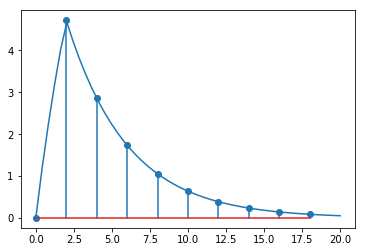

In [23]:
plot_discrete(Gz_seborg, terms, parameters[Dt])
plt.plot(ts, values(response - response.subs(t, t-parameters[Dt]), ts))